## データの読込

In [1]:
import pandas as pd
df = pd.read_csv("vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


## 解釈性

In [2]:
import os
import time
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from natsort import natsorted 

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import shap

import warnings
warnings.simplefilter('ignore')

In [3]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

In [5]:
### パイプライン

# 数値データカラム名を取得
number_columns = X_train.select_dtypes(include="number").columns
number_columns = list(number_columns)

# カテゴリデータカラム名を取得
category_columns = X_train.select_dtypes(include="object").columns
category_columns = list(category_columns)

# カテゴリデータカラムの各カラムのカテゴリーの数を取得
category_unique_num = X_train.select_dtypes(include="object").nunique()

# 数値データ用の変換
numeric_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
)

# カテゴリーの数にしきい値を設けて、カテゴリー数の多いカラムと少ないカラムに分ける
thread = 10
many_kinds_category_columns = category_unique_num[category_unique_num >= thread].index
many_kinds_category_columns = list(many_kinds_category_columns)

few_kinds_category_columns = category_unique_num[category_unique_num < thread].index
few_kinds_category_columns = list(few_kinds_category_columns)

# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping = []

for column in many_kinds_category_columns:
    ordinal_one_cols_mapping = []
    for category in natsorted(X_train[column].unique()):
        ordinal_one_cols_mapping.append(category)

    ordinal_all_cols_mapping.append(ordinal_one_cols_mapping)

# カテゴリー数が多いカテゴリーデータ用の変換
many_kinds_categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(
                handle_unknown = 'use_encoded_value', # 未知数をunknown valueに置き換える設定
                unknown_value = -1,
                categories = ordinal_all_cols_mapping
            )
        )
])

# カテゴリー数が少ないカテゴリーデータ用の変換
few_kinds_categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

# ColumnTransformerの作成
columns_transformers = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, number_columns),
        ('many_kinds', many_kinds_categorical_transformer, many_kinds_category_columns),
        ('few_kinds', few_kinds_categorical_transformer, few_kinds_category_columns)
    ]
)

# カラム変換用のパイプラインの作成
transformer = Pipeline(
    [
        ("columns_transformers", columns_transformers),
    ]
)

# パイプラインの作成
pipe = Pipeline(
    [
        ("columns_transformers", columns_transformers),
        ('model', lgb.LGBMRegressor(random_state=42))
     ]
)

In [6]:
### Nullのみで削除されるカラムを削除
print(len(number_columns))

for column in ["VGChartz_Score", "Total_Shipped"]:
    number_columns.remove(column)

print(len(number_columns))

8
6


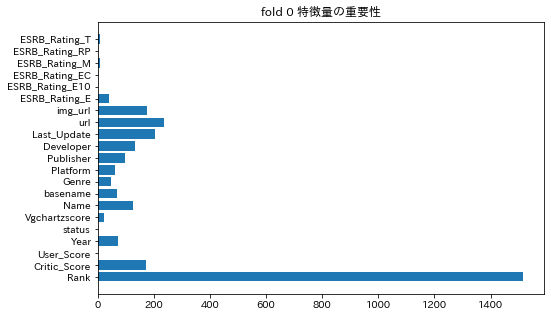

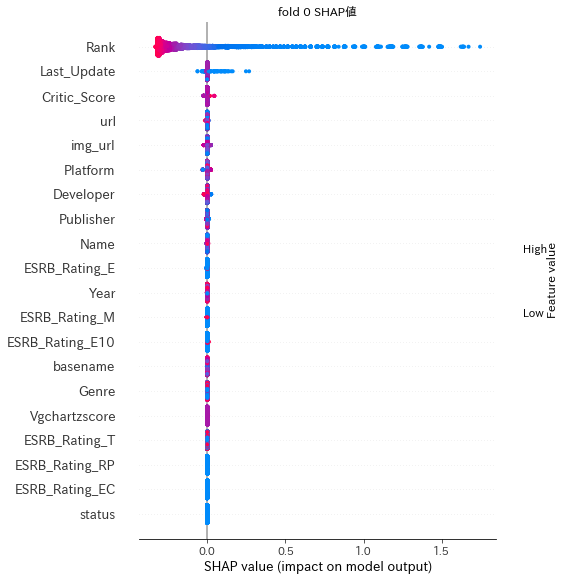

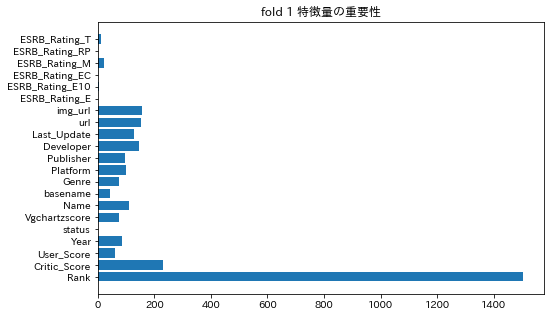

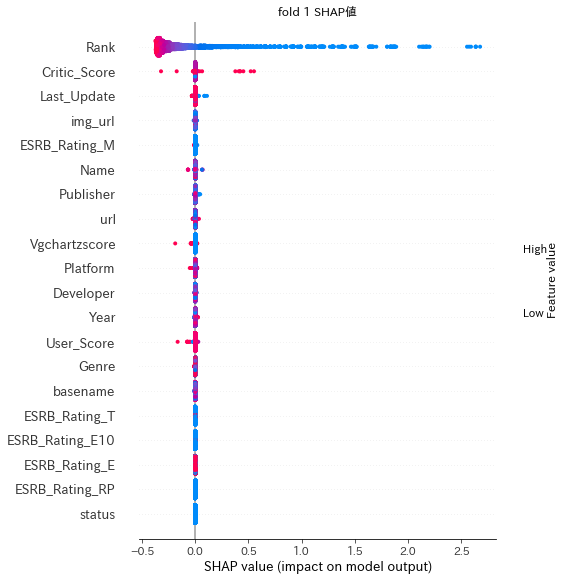

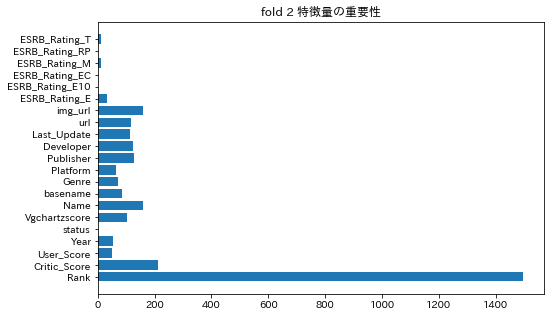

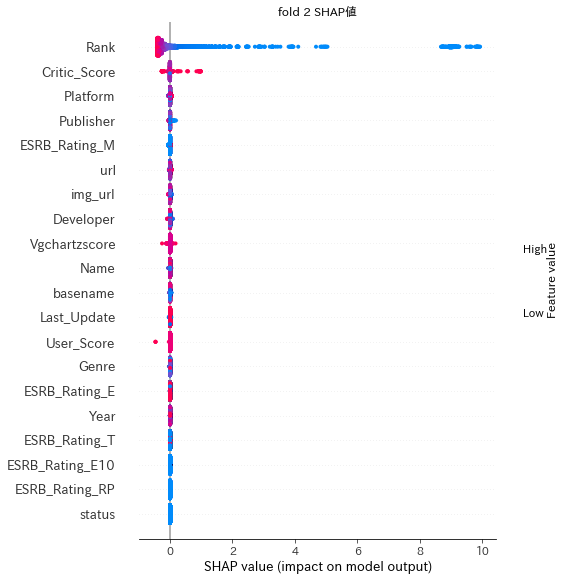

RMSE: [0.48421116383050283, 0.09542190741763229, 0.03241827887443953]
RMSE: 0.20401711670752487


In [7]:
# 学習・推論
gkf = GroupKFold(n_splits=3)

groups = X_train["Genre"]

cv_result_lgbm = []

for i, (train_index, test_index) in enumerate(gkf.split(X_train, y_train, groups)):
    X_train_gkf, X_test_gkf = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # 学習、推論
    pipe.fit(X_train_gkf, y_train_gkf)

    y_pred = pipe.predict(X_test_gkf)

    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_lgbm.append(rmse)

    # shap
    X_train_gkf = columns_transformers.fit_transform(X_train_gkf)
    X_test_gkf = columns_transformers.fit_transform(X_test_gkf)

    # OneHotを考慮したの全カラム作成
    all_columns = number_columns + \
                            many_kinds_category_columns + \
                            pipe["columns_transformers"].transformers_[2][1]["onehot"].get_feature_names(few_kinds_category_columns).tolist()

    X_train_gkf = pd.DataFrame(
        X_train_gkf,
        columns=all_columns
        )

    X_test_gkf = pd.DataFrame(
        X_test_gkf,
        columns=all_columns
        )
    
    # 特徴量の重要性
    plt.figure(figsize=(8, 5))
    plt.title(f"fold {i} 特徴量の重要性")
    plt.barh(
        X_test_gkf.columns,
        pipe["model"].feature_importances_,
    )
    plt.show()


    # shap
    explainer = shap.TreeExplainer(pipe['model'])
    shap_values = explainer.shap_values(X_test_gkf)

    plt.title(f"fold {i} SHAP値")
    shap.summary_plot(
                shap_values=shap_values,
                features=X_test_gkf,
                feature_names=X_test_gkf.columns
                )
    plt.show()

print("RMSE:", cv_result_lgbm)
print("RMSE:", np.mean(cv_result_lgbm))